## Data Analysis

In [1]:
#Install Packages

#!pip install openpyxl
#!pip install pandas
#!pip install matplotlib
#!pip install scipy
#!pip install simplejson
#!pip install seaborn

In [2]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime
import json
import pickle
import seaborn as sns
import calendar

#### Assumptions

The objective is to analyse the profitability of investing in Cryptocurrency mining to make use of the excess energy produced in renewable energy.

In [3]:
# Load variables from the Global_Variables file

with open('Global_Variables.pkl', 'rb') as f:
    Global_Variables = pickle.load(f)

In [4]:
#Assumptions from CHE Report

#BTC Mining
Basis_MW = Global_Variables['Basis_MW'] #MW
Hardware_Eff = Global_Variables['Hardware_Eff'] #Percentage
W_from_Renewables = Global_Variables['W_from_Renewables'] #GW
P_from_Renewables = Global_Variables['P_from_Renewables'] #GW
P_from_Solar = Global_Variables['P_from_Solar']
Cooling = Global_Variables['Cooling'] #Percentage of excess energy produced by Solar Energy
Solar_Plant_W = Global_Variables['Solar_Plant_W'] #GW

#Solar Plant
#PV_Capacity = Global_Variables['PV_Capacity'] #MW Maximum capacity
Capital_Cost_PV = Global_Variables['Capital_Cost_PV'] #$/MW
PV_Plant_Cost = Global_Variables['PV_Plant_Cost'] #$
PV_plant_capacity  = Global_Variables['PV_plant_capacity'] #MW
AC_capacity = Global_Variables['AC_capacity'] #MW Maximum capacity
Off_peak_hours = Global_Variables['Off_peak_hours']
Energy_Demand = Global_Variables['Energy_Demand']
AC_capacity = Global_Variables['AC_capacity'] #MW Maximum capacity

#Date of data extraction from Blockchain.com
current_year = Global_Variables['current_year']
last_date =  Global_Variables['last_date']
previous_year = Global_Variables['previous_year']
months = Global_Variables['months']
days_in_month = Global_Variables['days_in_month']
hours = Global_Variables['hours']

Data Sources:
- https://www.asicminervalue.com/
- https://www.blockchain.com/explorer/charts/

In [5]:
#Import Files

#Data used as basis
Solar_Data = Global_Variables['Solar_Data']
sheet_name_SolarData = 'Postmasburg'
skiprows = 31

#Data used as basis
Crypto_Data = Global_Variables['Crypto_Data']
#ASIC_df = pd.read_excel(Crypto_Data, sheet_name='Bitcoin Asic_data')
ASIC_df = Crypto_Data

#Bitcoin Data
hashrate_BTC = Global_Variables['hashrate_BTC']
revenue_BTC = Global_Variables['revenue_BTC']

#JSON file paths
file_paths = [hashrate_BTC,revenue_BTC]

In [6]:
start_date = pd.to_datetime(f'{previous_year}-01-01')
end_date = pd.to_datetime(last_date) - pd.Timedelta(days=366)

print(f"Start Date -> {start_date}")
print(f"End Date -> {end_date}")

Start Date -> 2023-01-01 00:00:00
End Date -> 2023-10-25 00:00:00


### PV Plant Data

##### Data Cleaning

In [7]:
data = []

for month in months:
    days = days_in_month[month - 1]
    for day in range(1, days + 1):
        for hour in hours:
            if hour in Off_peak_hours:
                energy_demand = 0
            else:
                energy_demand = Energy_Demand
            data.append({'Day': day, 'Month': month, 'Hour': hour, 'Energy Demand (MW)': energy_demand})

df_Energy_Demand = pd.DataFrame(data)


In [8]:
df_Energy_Demand.head()

,Day,Month,Hour,Energy Demand (MW)
0,1,1,0,0
1,1,1,1,0
2,1,1,2,0
3,1,1,3,0
4,1,1,4,0


In [9]:
#Create new columns with full dates

df_Energy_Demand['Day-Month-Year'] = pd.to_datetime(df_Energy_Demand['Day'].astype(str) + '-' + df_Energy_Demand['Month'].astype(str) + '-' + str(previous_year), 
                            format='%d-%m-%Y', errors='coerce')

# Replace year with 2024 for dates within the range
df_Energy_Demand['Day-Month-Year'] = df_Energy_Demand['Day-Month-Year'].apply(lambda x: x.replace(year=int(current_year)) if start_date <= x <= end_date else x)

df_Energy_Demand['Day-Month'] = df_Energy_Demand['Day-Month-Year'].dt.strftime('%d-%m')

df_Energy_Demand['Date'] = pd.to_datetime(df_Energy_Demand['Day-Month-Year'], format='%d-%B-%Y')
df_Energy_Demand = df_Energy_Demand[['Date','Day-Month','Hour','Energy Demand (MW)']]

df_Energy_Demand.head()

,Date,Day-Month,Hour,Energy Demand (MW)
0,2024-01-01,01-01,0,0
1,2024-01-01,01-01,1,0
2,2024-01-01,01-01,2,0
3,2024-01-01,01-01,3,0
4,2024-01-01,01-01,4,0


In [10]:
#Read Files with validation check

df_PV = pd.read_excel(Solar_Data, sheet_name=sheet_name_SolarData, skiprows=skiprows)
df_PV.head()


,Month,Day,Hour,Beam Irradiance (W/m2),Diffuse Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Albedo,Plane of Array Irradiance (W/m2),Cell Temperature (C),DC Array Output (W),AC System Output (W)
0,1,1,0,0,0,20.1,2.9,0.2,0.0,20.1,0.0,0.0
1,1,1,1,0,0,18.7,3.0,0.2,0.0,18.7,0.0,0.0
2,1,1,2,0,0,19.2,1.3,0.2,0.0,19.2,0.0,0.0
3,1,1,3,0,0,18.5,1.1,0.2,0.0,18.5,0.0,0.0
4,1,1,4,0,0,18.3,1.0,0.2,0.0,18.3,0.0,0.0


In [11]:
#Clean Data

df_PV['Month'] = df_PV['Month'].fillna(method='ffill')

C:\Users\HeldaMandlate\AppData\Local\Temp\ipykernel_9940\49855558.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_PV['Month'] = df_PV['Month'].fillna(method='ffill')


In [12]:
#List of all rows entries in column Month

df_PV['Month'].unique().tolist()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [13]:
df_PV.columns

Index(['Month', 'Day', 'Hour', 'Beam Irradiance (W/m2)',
       'Diffuse Irradiance (W/m2)', 'Ambient Temperature (C)',
       'Wind Speed (m/s)', 'Albedo', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'DC Array Output (W)', 'AC System Output (W)'],
      dtype='object')

In [14]:
#Create new columns with full dates

df_PV['Day-Month-Year'] = pd.to_datetime(df_PV['Day'].astype(str) + '-' + df_PV['Month'].astype(str) + '-' + str(previous_year), 
                            format='%d-%m-%Y', errors='coerce')

df_PV['Day-Month'] = df_PV['Day-Month-Year'].dt.strftime('%d-%m')

df_PV['Date'] = pd.to_datetime(df_PV['Day-Month-Year'], format='%d-%B-%Y')
df_PV = df_PV[['Date','Day-Month','Hour','AC System Output (W)']]

In [15]:
df_PV.head()

,Date,Day-Month,Hour,AC System Output (W)
0,2023-01-01,01-01,0,0.0
1,2023-01-01,01-01,1,0.0
2,2023-01-01,01-01,2,0.0
3,2023-01-01,01-01,3,0.0
4,2023-01-01,01-01,4,0.0


In [16]:
#Surplus Energy in W

df_PV['AC System Output (MW)'] = df_PV['AC System Output (W)']/1000000
df_PV['Energy Generation (MW)'] = (df_PV['AC System Output (MW)']/AC_capacity)*PV_plant_capacity

df_PV['Energy for Mining (MW)'] = ((df_PV['Energy Generation (MW)'] - df_Energy_Demand['Energy Demand (MW)']) ).where(
    ((df_PV['Energy Generation (MW)'] - df_Energy_Demand['Energy Demand (MW)']) ) > 0, 0)


df_PV['Energy for Mining (MW)'] = df_PV['Energy for Mining (MW)']*(1-Cooling)

# Replace year with 2024 for dates within the range
df_PV['Date'] = df_PV['Date'].apply(lambda x: x.replace(year=int(current_year)) if start_date <= x <= end_date else x)

relevant_columns = ['Date', 'Day-Month', 'Hour', 'Energy for Mining (MW)']
df_PV = df_PV[relevant_columns]

In [17]:
df_PV.head()

,Date,Day-Month,Hour,Energy for Mining (MW)
0,2024-01-01,01-01,0,0.0
1,2024-01-01,01-01,1,0.0
2,2024-01-01,01-01,2,0.0
3,2024-01-01,01-01,3,0.0
4,2024-01-01,01-01,4,0.0


In [18]:
df_PV = pd.merge(df_PV, df_Energy_Demand, how='inner', on=['Day-Month', 'Hour'])

In [19]:
df_PV.head()

,Date_x,Day-Month,Hour,Energy for Mining (MW),Date_y,Energy Demand (MW)
0,2024-01-01,01-01,0,0.0,2024-01-01,0
1,2024-01-01,01-01,1,0.0,2024-01-01,0
2,2024-01-01,01-01,2,0.0,2024-01-01,0
3,2024-01-01,01-01,3,0.0,2024-01-01,0
4,2024-01-01,01-01,4,0.0,2024-01-01,0


In [20]:
df_PV['Date'] = df_PV['Date_x']
relevant_columns = ['Date','Hour','Energy for Mining (MW)']
df_PV = df_PV[relevant_columns]
df_PV.head()

,Date,Hour,Energy for Mining (MW)
0,2024-01-01,0,0.0
1,2024-01-01,1,0.0
2,2024-01-01,2,0.0
3,2024-01-01,3,0.0
4,2024-01-01,4,0.0


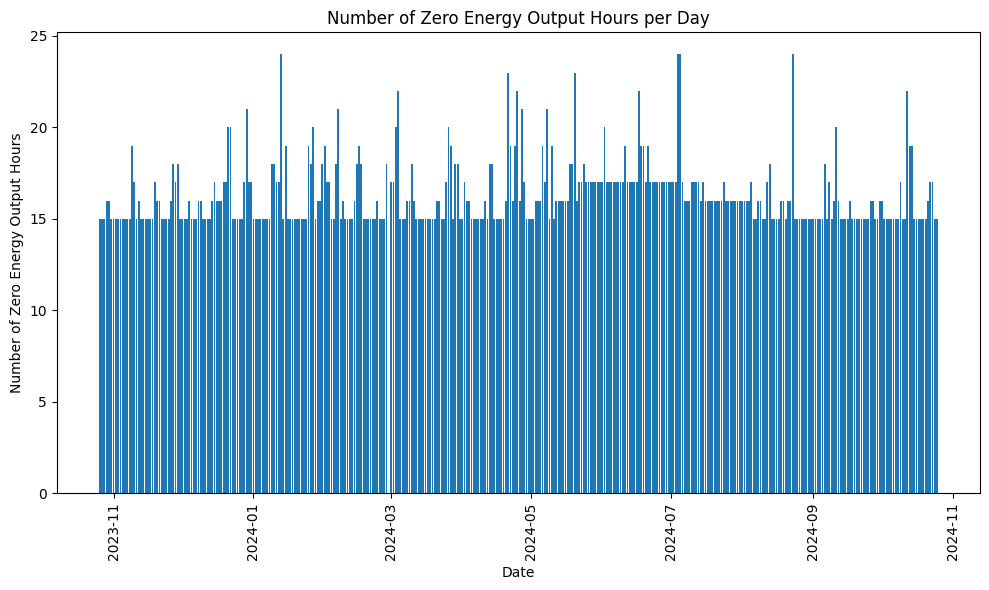

In [21]:
#Hours in a day with no Energy Production
df_zero_energy_output = df_PV[df_PV['Energy for Mining (MW)'] == 0]

#Count the number of hours per day with zero energy output
zero_hours_per_day = df_zero_energy_output.groupby('Date')['Hour'].count().reset_index()
zero_hours_per_day.columns = ['Date', 'Zero_Hours']

#Identify which hours have zero energy output for each day
zero_hours_by_day = df_zero_energy_output.groupby('Date')['Hour'].apply(list).reset_index()

#Display results: Plot bar chart for the number of zero energy output hours per day
plt.figure(figsize=(10,6))
plt.bar(zero_hours_per_day['Date'], zero_hours_per_day['Zero_Hours'])
plt.xlabel('Date')
plt.ylabel('Number of Zero Energy Output Hours')
plt.title('Number of Zero Energy Output Hours per Day')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

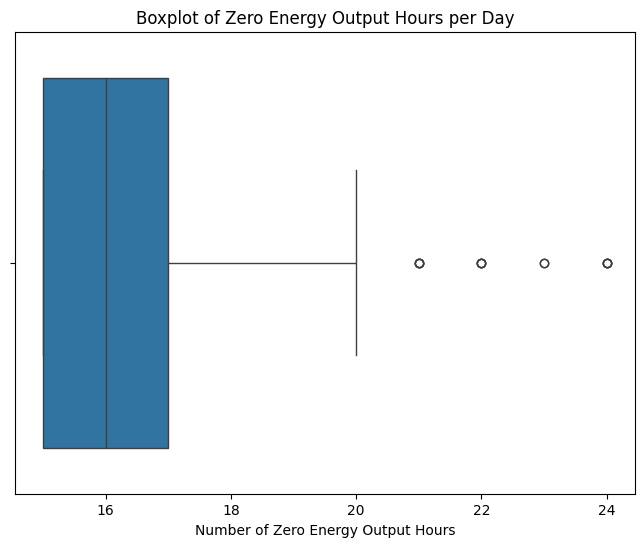

In [22]:
#Boxplot for the number of zero energy consumption hours per day
plt.figure(figsize=(8, 6))
sns.boxplot(x=zero_hours_per_day['Zero_Hours'])

plt.xlabel('Number of Zero Energy Output Hours')
plt.title('Boxplot of Zero Energy Output Hours per Day')
plt.show()


C:\Users\HeldaMandlate\AppData\Local\Temp\ipykernel_9940\2714940888.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(monthly_data, patch_artist=True, labels=[calendar.month_name[i] for i in range(1, 13)])


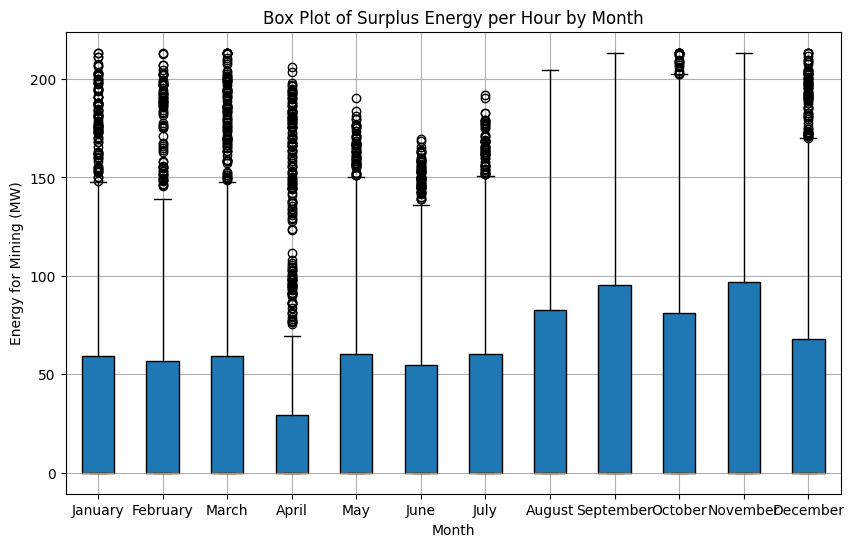

In [23]:
#Box plot per month of Energy Available for Mining, ie: Surplus Energy
df_PV['Month'] = df_PV['Date'].dt.month

monthly_data = [df_PV[df_PV['Month'] == month]['Energy for Mining (MW)'] for month in range(1, 13)]

plt.figure(figsize=(10, 6))
plt.boxplot(monthly_data, patch_artist=True, labels=[calendar.month_name[i] for i in range(1, 13)])

plt.title('Box Plot of Surplus Energy per Hour by Month')
plt.xlabel('Month')
plt.ylabel('Energy for Mining (MW)')
plt.grid(True)

plt.show()

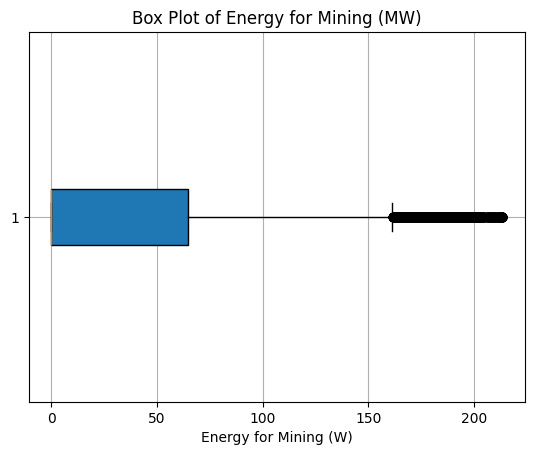

In [24]:
#Boxplot to view data distribution on Surplus per hour in one year

plt.boxplot([df_PV['Energy for Mining (MW)']], vert=False, patch_artist=True)
plt.title('Box Plot of Energy for Mining (MW)')
plt.xlabel('Energy for Mining (W)')
plt.grid(True)
plt.show()

In [25]:
ASIC_df = ASIC_df.loc[ASIC_df['Rig Type'] != 'ASIC']
ASIC_df.head()

,Model,Release,Hashrate (Th/s),Power (W),Algorithm,Income ($/day),Electricity Cost ($/day),With Electricity,Without Electricity,Efficiency (j/Gh),Price ($),Noise db,Cooling,Seller,Days to Breakeven,Rig Type
12,Core i7 950,2009,0.000019,157.50,SHA-256,NaN,NaN,NaN,NaN,NaN,70.0,NaN,None,None,NaN,CPU
13,Atom N450,2009,0.000100,322.58,SHA-256,NaN,NaN,NaN,NaN,NaN,15.0,NaN,None,None,NaN,CPU
14,ATI 4850,2010,0.000101,109.78,SHA-256,NaN,NaN,NaN,NaN,NaN,90.0,NaN,None,None,NaN,GPU
15,ATI 5770,2010,0.000215,110.00,SHA-256,NaN,NaN,NaN,NaN,NaN,30.0,NaN,None,None,NaN,GPU
16,The Single,2011,0.000832,80.00,SHA-256,NaN,NaN,NaN,NaN,NaN,795.0,NaN,None,None,NaN,FPGA


In [26]:
ASIC_df.columns

Index(['Model', 'Release', 'Hashrate (Th/s)', 'Power (W)', 'Algorithm',
       'Income ($/day)', 'Electricity Cost ($/day)', 'With Electricity',
       'Without Electricity', 'Efficiency (j/Gh)', 'Price ($)', 'Noise db',
       'Cooling', 'Seller', 'Days to Breakeven', 'Rig Type'],
      dtype='object')

In [27]:
#Create dictionary with ASIC data

column_pairs = ['Release', 'Hashrate (Th/s)', 'Power (W)', 'Algorithm',
       'Income ($/day)', 'Electricity Cost ($/day)', 'With Electricity',
       'Without Electricity', 'Efficiency (j/Gh)', 'Price ($)', 'Noise db',
       'Cooling', 'Seller', 'Days to Breakeven']
dicts = {}

for col in column_pairs:
    dict_name = f"dict_{col}"
    dicts[dict_name] = ASIC_df.set_index('Model')[col].to_dict()

for name, dictionary in dicts.items():
    print(f"{name} -> {dictionary}")

dict_Release -> {'Core i7 950': '2009', 'Atom N450': '2009', 'ATI 4850': '2010', 'ATI 5770': '2010', 'The Single': '2011', 'Rig Box': '2011'}
dict_Hashrate (Th/s) -> {'Core i7 950': 1.9e-05, 'Atom N450': 0.0001, 'ATI 4850': 0.000101, 'ATI 5770': 0.000215, 'The Single': 0.000832, 'Rig Box': 0.05}
dict_Power (W) -> {'Core i7 950': 157.5, 'Atom N450': 322.58, 'ATI 4850': 109.78, 'ATI 5770': 110.0, 'The Single': 80.0, 'Rig Box': 2450.98}
dict_Algorithm -> {'Core i7 950': 'SHA-256', 'Atom N450': 'SHA-256', 'ATI 4850': 'SHA-256', 'ATI 5770': 'SHA-256', 'The Single': 'SHA-256', 'Rig Box': 'SHA-256'}
dict_Income ($/day) -> {'Core i7 950': nan, 'Atom N450': nan, 'ATI 4850': nan, 'ATI 5770': nan, 'The Single': nan, 'Rig Box': nan}
dict_Electricity Cost ($/day) -> {'Core i7 950': nan, 'Atom N450': nan, 'ATI 4850': nan, 'ATI 5770': nan, 'The Single': nan, 'Rig Box': nan}
dict_With Electricity -> {'Core i7 950': nan, 'Atom N450': nan, 'ATI 4850': nan, 'ATI 5770': nan, 'The Single': nan, 'Rig Box': 

In [28]:
# Number of Rigs per Model
for model, power_ in dicts['dict_Power (W)'].items():
    df_PV[model] = (df_PV['Energy for Mining (MW)']*1000000 / power_).round().astype(int)

df_PV.head()


,Date,Hour,Energy for Mining (MW),Month,Core i7 950,Atom N450,ATI 4850,ATI 5770,The Single,Rig Box
0,2024-01-01,0,0.0,1,0,0,0,0,0,0
1,2024-01-01,1,0.0,1,0,0,0,0,0,0
2,2024-01-01,2,0.0,1,0,0,0,0,0,0
3,2024-01-01,3,0.0,1,0,0,0,0,0,0
4,2024-01-01,4,0.0,1,0,0,0,0,0,0


In [29]:
df_PV.columns

Index(['Date', 'Hour', 'Energy for Mining (MW)', 'Month', 'Core i7 950',
       'Atom N450', 'ATI 4850', 'ATI 5770', 'The Single', 'Rig Box'],
      dtype='object')

In [30]:
columns_to_exclude = ['Date', 'Hour', 'Energy for Mining (MW)', 'Month',
       #'MicroBT WhatsMiner M63S',
       #'Bitmain Antminer S21 Hyd (335Th)', 'MicroBT WhatsMiner M63',
       #'MicroBT WhatsMiner M66S', 'Bitmain Antminer S21 Pro (234Th)',
       #'Bitmain Antminer S21 (200Th)', 'Bitmain Antminer T21 (190Th)',
       #'MicroBT WhatsMiner M60S', 'Canaan Avalon A1566',
       #'MicroBT WhatsMiner M60', 'Bitmain Antminer S19j Pro (104Th)',
       #'Bitmain Antminer S19 Pro (110Th)'
       ]

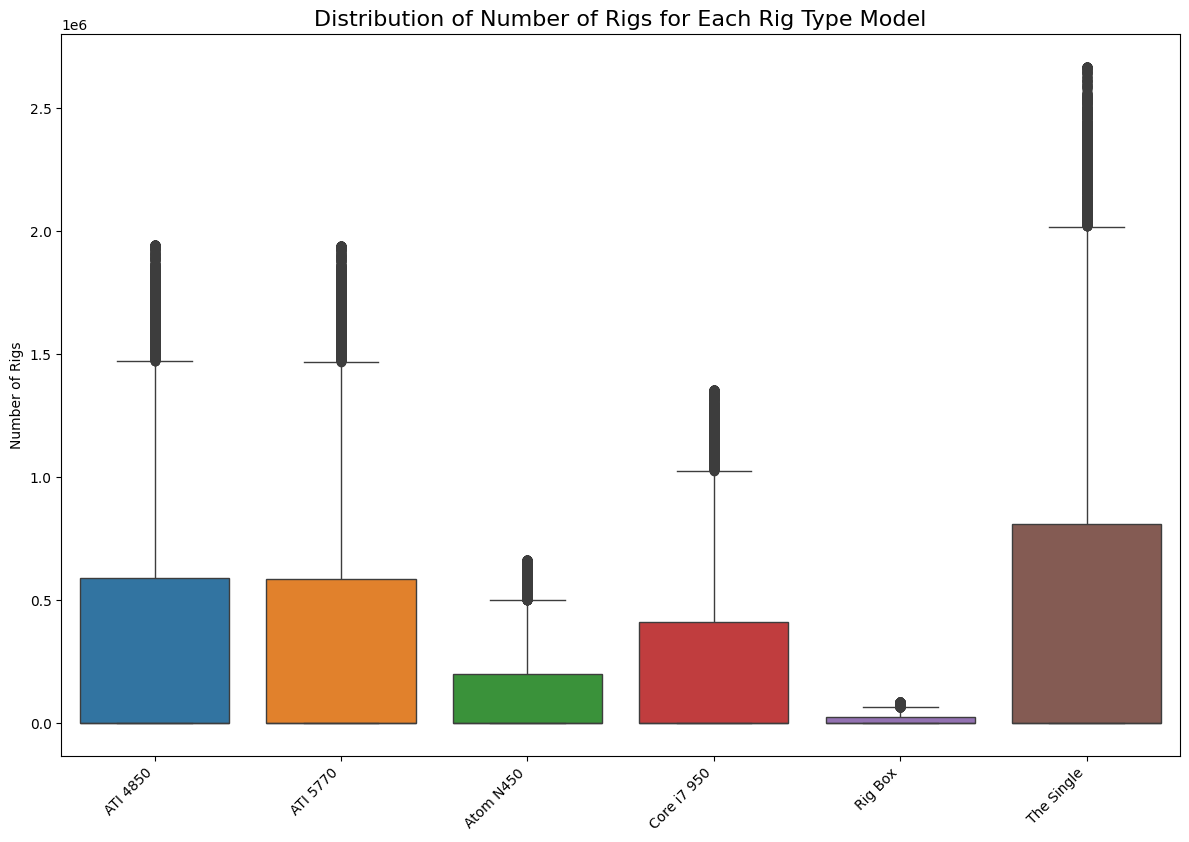

In [31]:
plt.figure(figsize=(12, 8))

columns_to_plot = df_PV.columns.difference(columns_to_exclude)

sns.boxplot(data=df_PV[columns_to_plot])

plt.title('Distribution of Number of Rigs for Each Rig Type Model', fontsize=16)
plt.ylabel('Number of Rigs')

plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

In [32]:
numeric_columns = df_PV.drop(columns=columns_to_exclude).select_dtypes(include=[np.number])

max_values = numeric_columns.max().to_dict()

print(max_values)

{'Core i7 950': 1354497, 'Atom N450': 661335, 'ATI 4850': 1943281, 'ATI 5770': 1939394, 'The Single': 2666667, 'Rig Box': 87040}


In [33]:
def plot_max_values_with_groups(max_values, model_groups=None, title="Number of Rigs per Rig Type Model"):

    # Define color palette and map for grouped models
    color_palette = ['skyblue', 'orange', 'green', 'purple', 'blue', 'pink']
    color_map = {}
    
    if model_groups:
        for idx, (group, models) in enumerate(model_groups.items()):
            for model in models:
                color_map[model] = color_palette[idx % len(color_palette)]
                
    # Assign colors for each model in max_values, using grey if not in any group
    colors = [color_map.get(model, 'grey') for model in max_values.keys()]

    # Plot
    plt.figure(figsize=(12, 8))
    bars = sns.barplot(x=list(max_values.keys()), y=list(max_values.values()), palette=colors)

    # Set plot title, labels, and ticks
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Maximum Number of Rigs')
    plt.xlabel('Rig Type Model')
    plt.yticks([])

    # Annotate each bar with its height value
    for bar in bars.patches:
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height(), 
            f'{int(bar.get_height())}',
            ha='center', 
            va='bottom'
        )

    plt.tight_layout()
    
    plt.show()



C:\Users\HeldaMandlate\AppData\Local\Temp\ipykernel_9940\1516703295.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=list(max_values.keys()), y=list(max_values.values()), palette=colors)


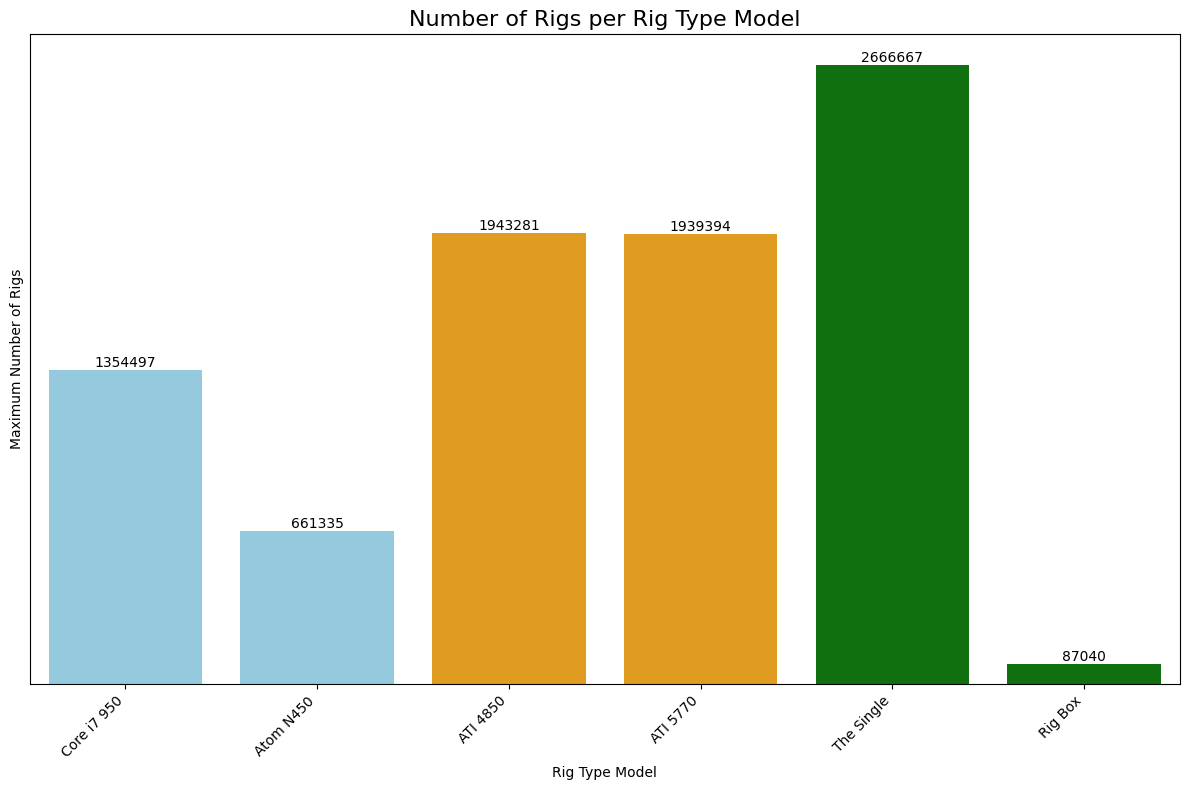

In [34]:

max_values = max_values
model_groups = {
    "Group1": ["Atom N450", "Core i7 950"],
    "Group2": ["ATI 5770", "ATI 4850"],
    "Group3": ["Rig Box", "The Single"]
}

plot_max_values_with_groups(max_values, model_groups=model_groups)


In [35]:
#Save all relevant variables

with open('RT_DataAnalysisVariables.pkl', 'wb') as f:
    pickle.dump({'NumberofRigsPerModel': max_values,
                 
                 }, f)